In [1]:
from mnist import MNIST
import numpy as np
from scipy.spatial.distance import cdist
import cv2
import math
#https://pypi.org/project/python-mnist
mndata = MNIST('./python-mnist/data')
images, labels = mndata.load_training()
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
delta = 1e-8
l = len(images)
n = len(images[0])
m = int(np.sqrt(n))
def random_mnist():
    p, q = np.random.randint(l), np.random.randint(l)
    p, q = np.float64(images[p]), np.float64(images[q])
    #p, q = cv2.resize(p.reshape(-1, m), (2, 2)), cv2.resize(q.reshape(-1, m), (2, 2))
    p, q = p.reshape(-1), q.reshape(-1)
    p[p < delta] = delta
    q[q < delta] = delta
    return p / sum(p), q / sum(q)

In [3]:
p, q = random_mnist()

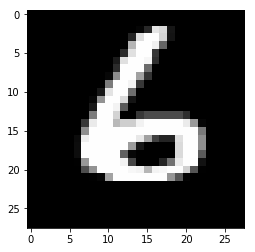

In [4]:
plot = True
if plot:
    plt.imshow(q.reshape(-1, m), cmap=plt.get_cmap('gray'))
    plt.show()

In [5]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

C = np.arange(m)
C = cartesian_product(C, C)
C = cdist(C, C)
C[C==0] = 1e-1
C /= C.max()
C.max()

1.0

In [6]:
one = np.ones(n, np.float64)
I = np.ones([n,n], np.float64)
def f_true(x):
    return (C * x).sum()

def mround(x):
    x += 1e-25
    r = p / x.dot(one)
    r[r>1] = 1.
    F = np.diag(r).dot(x)
    c = q / (x.T).dot(one)
    c[c>1] = 1.
    F = F.dot(np.diag(c))
    err_r = p - F.dot(one)
    err_c = q - (F.T).dot(one)
    return F + np.outer(err_r, err_c) / abs(err_r).sum()

In [7]:
import copy
from numpy import linalg
import time

eps = 1e-2
gamma = eps/3/np.log(n)

eps_f = eps   #function accuracy

In [8]:
def f_(x):
    y = (x.reshape(-1)).copy()
    y[x.reshape(-1) == 0.] = 1.
    y = y.reshape(n, -1)
    return (C * x).sum() + gamma * (x * np.log(y)).sum()

def x_(la, mu):
    x_star = np.exp((-C - np.outer(la, one) - np.outer(one, mu)) / gamma - I)
    #x_star = np.exp(-C/gamma) * np.exp(-np.outer(la, one)/gamma) * np.exp(-np.outer(one, mu)/gamma) / np.e
    return x_star

def phi_(lamu):
    x_star = x_(lamu[:n], lamu[n:])
    return lamu[:n].dot(p) + lamu[n:].dot(q) + gamma * x_star.sum()
                    
def grad_phi_(lamu):
    x_star = x_(lamu[:n], lamu[n:])
    return np.concatenate((p - x_star.dot(one), q - (x_star.T).dot(one)), 0), x_star

def phi_grad_phi_(lamu):
    x_star = x_(lamu[:n], lamu[n:])
    return lamu[:n].dot(p) + lamu[n:].dot(q) + gamma * x_star.sum(), np.concatenate((p - x_star.dot(one), q - (x_star.T).dot(one)), 0)

def phi_1d_(x, e):
    def f1d(h):
        return phi_(x + h * e)
    return f1d

def grad_phi_1d_(x, e):
    def gradf1d(h):
        return np.array(grad_phi_(x + h * e)[0].dot(e))
    return gradf1d

def phi_grad_phi_1d_(x, e):
    def fgradf1d(h):
        lamu = x + h * e
        x_star = x_(lamu[:n], lamu[n:])
        return lamu[:n].dot(p) + lamu[n:].dot(q) + gamma * x_star.sum(), np.array(np.concatenate((p - x_star.dot(one), q - (x_star.T).dot(one)), 0).dot(e))
    return fgradf1d    

# 1802.04367

In [9]:
def APDAGD(wtime):
    L = 1.
    betta = alpha = 0.
    x_hat = np.zeros([n, n], np.float64)
    z = np.zeros(2*n, np.float64)
    z_new = np.zeros(2*n, np.float64)
    eta = np.zeros(2*n, np.float64)
    eta_new  = np.zeros(2*n, np.float64)
    k=0
    phis = []
    xs = []
    times = []
    start_time = time.perf_counter()
    while True:
        L = L / 2
        while True:
            alpha_new = (1 + np.sqrt(4*L*betta + 1)) / 2 / L
            betta_new = betta + alpha_new
            tau = alpha_new / betta_new
            lamu_new = tau * z + (1 - tau) * eta
            
            #phi_new, grad_phi_new = phi_grad_phi_(lamu_new)
            x_star = x_(lamu_new[:n], lamu_new[n:])
            phi_new = lamu_new[:n].dot(p) + lamu_new[n:].dot(q) + gamma * x_star.sum()
            grad_phi_new = np.concatenate((p - x_star.dot(one), q - (x_star.T).dot(one)), 0)
            
            z_new = z - alpha_new * grad_phi_new
            eta_new = tau * z_new + (1-tau) * eta
            phi_eta = phi_(eta_new)
            if phi_eta <= phi_new + grad_phi_new.dot(eta_new - lamu_new) + L * ((eta_new - lamu_new)**2).sum() / 2:
                alpha, betta = alpha_new, betta_new
                z = z_new.copy()
                eta = eta_new.copy()
                break    
            L = L * 2
            del lamu_new, grad_phi_new, phi_eta
        x_hat = tau * x_star + (1 - tau) * x_hat
        xs.append(x_hat)
        phis.append(phi_new)    
        del phi_new
        ctime = time.perf_counter() - start_time
        times.append(ctime)
        if (ctime > wtime):
            break
        k=k+1
    return np.array(phis), np.array(xs), np.array(times), k

# 1809.05895 

In [10]:
def universal(f_, grad_f_, f_grad_f_, x, eps):
    L = 1.
    betta = alpha = 0.
    n = x.shape[0]
    while True:
        L = L / 2
        while True:
            f_x, grad_f_x = f_grad_f_(x)
            x_new = x - grad_f_x / L
            dx = x_new - x
            f_x_new = f_(x_new)
            if f_x_new <= f_x + grad_f_x.dot(dx) + L * dx.dot(dx) / 2:
                break    
            else:
                L = L * 2
        if(linalg.norm(grad_f_(x_new)) < eps):
            return x_new, f_x_new
        x = x_new.copy()
        
def binary(f_, grad_f_, h_0, max_steps, eps):
    f1 = f_(h_0)
    i = 0
    a_k = h_0
    while (i < max_steps):
        f2 = f_(2*h_0)
        if (f1 < f2):
            break
        else:
            f1 = f2
            h_0 = 2*h_0
        i += 1
    tau = (math.sqrt(5) + 1)/2
    if h_0 == h_0:
        a_k = 0
    else:
        a_k = h_0/4
    
    b_k = h_0
    
    N_min = math.floor(math.log((b_k - a_k)/eps, tau)) + 1
    y_k = a_k + (b_k - a_k)/tau/tau
    z_k = a_k + (b_k - a_k)/tau
    current = f_(y_k)
    IsNextZ = 1
    h = y_k
    k = 1
    #while (k < N_min):
    while True:
        if (IsNextZ == 1):
            new = f_(z_k)
            if (current <= new):
                b_k = a_k + (b_k - a_k)/tau
                z_k = y_k
                y_k = a_k + (b_k - a_k)/tau/tau
                IsNextZ = 0
            else:
                a_k = y_k
                y_k = z_k
                z_k = a_k + (b_k - a_k)/tau
                current = new
                h = z_k
        elif (IsNextZ == 0):
            new = f_(y_k)
            if (new <= current):
                b_k = a_k + (b_k - a_k)/tau
                z_k = y_k
                y_k = a_k + (b_k - a_k)/tau/tau
                current = new
                h = y_k
            else:
                a_k = y_k
                y_k = z_k
                z_k = a_k + (b_k - a_k)/tau
                IsNextZ = 1
        if(linalg.norm(grad_f_(h)) < eps):
            break
        k += 1 
    return h

def binary_ab(f, xleft, xright, eps_search):
    N = math.floor(np.log2(abs(xright - xleft)/eps_search)) + 1
    k=0
    a = xleft + (xright - xleft)/4
    b = xleft + (xright - xleft)/2
    fa = f(a)
    fb = f(b)
    fleft = f(xleft)
    fright = f(xright)
    while fb - fa > eps_search or k < N:
        #print(fa, fb)
        if fa > fb:
            fleft = fa
            xleft = a
        elif fb > fa:
            fright = fb
            xright = b
        else:
            break
        k+=1
    
        a = xleft + (xright - xleft)/4
        b = xleft + (xright - xleft)/2
        fa = f(a)
        fb = f(b)
        
    #return xleft, fleft
    
    minf = min(fleft, fa, fb, fright)
    if minf == fleft:
        return xleft, fleft
    elif minf == fa:
        return a, fa
    elif minf == fb:
        return b, fb
    elif minf == fright:
        return xright, fright, 

def binary_n(f, x0, N, eps_search):
    xleft = 0
    xright = x0
    
    fleft = f(xleft)
    fright = f(xright)
    k = 0
    while k < N:
        if fleft < fright:
            break
        else:
            fleft = fright
            xleft = xright
            xright *= 2
            fright = f(xright)
        k+=1

    if xleft == x0:
        xleft = 0
    else:
        xleft /= 4
        
    #fleft < fright
    N = math.floor(np.log2(abs(xright - xleft)/eps_search)) + 1
    
    return binary_ab(f, xleft, xright, eps_search)

In [11]:
def AGMsDR(wtime, eps_search, design='u'):
    A = 0.
    x = np.zeros(2*n, np.float64)
    v = x.copy()
    psi_A = 0.5
    psi_b = x.copy()
    k=0
    primal_mean = np.zeros([n, n], np.float64)
    phis = []
    primals = []
    times = []
    start_time = time.perf_counter()
    while True:
        beta, _ = binary_ab(phi_1d_(v, x - v), 0, 1, 1e-3)
        f_y = phi_1d_(v, x - v)(beta)
        #beta, f_y =  universal(phi_1d_(v, x-v), grad_phi_1d_(v, x-v), phi_grad_phi_1d_(v, x-v), np.zeros(1, np.float64), 0.000001)
        y = v + beta * (x - v)
        grad_f_y, primal_var = grad_phi_(y)
        norm_grad_f_y = np.linalg.norm(grad_f_y)
        grad_f_sharp = grad_f_y / norm_grad_f_y
        if design == 'u':
            h, f_x =  universal(phi_1d_(y, -grad_f_sharp), grad_phi_1d_(y, -grad_f_sharp), phi_grad_phi_1d_(y, -grad_f_sharp), 0.*np.ones(1, np.float64), eps_search)
        else:
            h =  binary(phi_1d_(y, -grad_f_sharp), grad_phi_1d_(y, -grad_f_sharp), 1e-1, 100, eps_search)
            f_x = phi_1d_(y, -grad_f_sharp)(h)
        x = y - h * grad_f_sharp
        g, a = (f_x - f_y), norm_grad_f_y**2
        alpha = (-g + np.sqrt(g*g - 2*a*g*A)) / a 
        A = A + alpha
        psi_b = psi_b + alpha * (grad_f_y)
        v = -psi_b / psi_A
        k = k + 1
        primal_mean += alpha * primal_var
        if A != 0:
            primals.append(primal_mean / A)
        else:
            primals.append(1e-8 * np.ones([n, n], np.float64))
        phis.append(f_x)
        ctime = time.perf_counter() - start_time
        times.append(ctime)
        if (ctime > wtime):
            break
    return np.array(phis), np.array(primals),  np.array(times), k


def UAGMsDR(wtime, eps_search, eps_f, design='u'):
    k = 0
    x = np.zeros(2*n, np.float64)
    v = copy.deepcopy(x)
    A = 0
    primal_mean = np.zeros([n, n], np.float64)
    phis = []
    primals = []
    times = []
    start_time = time.perf_counter()
    while True:
        beta, _ = binary_ab(phi_1d_(v, x - v), 0, 1, 1e-3)
        f_y = phi_1d_(v, x - v)(beta)
        y = v + beta*(x - v)
        
        grad_f_y, primal_var = grad_phi_(y)
        norm_grad_f_y = np.linalg.norm(grad_f_y)
        grad_f_sharp = grad_f_y / norm_grad_f_y
        
        if design == 'u':
            h, f_x =  universal(phi_1d_(y, -grad_f_sharp), grad_phi_1d_(y, -grad_f_sharp), phi_grad_phi_1d_(y, -grad_f_sharp), 0.*np.ones(1, np.float64), eps_search)
        else:
            h =  binary(phi_1d_(y, -grad_f_sharp), grad_phi_1d_(y, -grad_f_sharp), 1e-1, 100, eps_search)
            f_x = phi_1d_(y, -grad_f_sharp)(h)
        x = y - h*grad_f_sharp
        
        const = (f_y - f_x + eps_f/2)
        alpha = (const + (const**2 + 2*(const-eps_f/2)*A*(norm_grad_f_y**2))**0.5)/(norm_grad_f_y**2)
        A += alpha
        v -= alpha * grad_f_y
        k += 1
        primal_mean += alpha * primal_var
        
        if A != 0:
            primals.append(primal_mean / A)
        else:
            primals.append(1e-8 * np.ones([n, n], np.float64))
        phis.append(f_x)
        ctime = time.perf_counter() - start_time
        times.append(ctime)
        if (ctime > wtime):
            break
    return np.array(phis), np.array(primals), np.array(times), k

# Q -  standard simplex

In [12]:
def f_simplex_(x):
    y = (x.reshape(-1)).copy()
    y[x.reshape(-1) == 0.] = 1.
    y = y.reshape(n, -1)
    return (C * x).sum() + gamma * (x * np.log(y)).sum()

def x_s_(la, mu):
    x_star = np.exp((-C - np.outer(la, one) - np.outer(one, mu)) / gamma - I)
    return x_star / x_star.sum()

def x_simplex_(la, mu):
    x_star = np.exp((-C - np.outer(la, one) - np.outer(one, mu)) / gamma - I)
    return x_star

def phi_simplex_(lamu):
    x_star = x_simplex_(lamu[:n], lamu[n:])
    s = x_star.sum()
    return lamu[:n].dot(p) + lamu[n:].dot(q) + gamma * (1 + np.log(s))
                    
def grad_phi_simplex_(lamu):
    x_star = x_simplex_(lamu[:n], lamu[n:])
    x_star = x_star / x_star.sum()
    return np.concatenate((p - x_star.dot(one), q - (x_star.T).dot(one)), 0), x_star

def phi_grad_phi_simplex_(lamu):
    x_star = x_simplex_(lamu[:n], lamu[n:])
    s = x_star.sum()
    x_star = x_star / s
    return lamu[:n].dot(p) + lamu[n:].dot(q) + gamma * (1 + np.log(s)), np.concatenate((p - x_star.dot(one), q - (x_star.T).dot(one)), 0)

def phi_1d_simplex_(x, e):
    def f1d(h):
        return phi_simplex_(x + h * e)
    return f1d

def grad_phi_1d_simplex_(x, e):
    def gradf1d(h):
        return np.array(grad_phi_simplex_(x + h * e)[0].dot(e))
    return gradf1d

def phi_grad_phi_1d_simplex_(x, e):
    def fgradf1d(h):
        lamu = x + h * e
        x_star = x_simplex_(lamu[:n], lamu[n:])
        s = x_star.sum()
        x_star = x_star / s
        return lamu[:n].dot(p) + lamu[n:].dot(q) + gamma * (1 + np.log(s)), np.array(np.concatenate((p - x_star.dot(one), q - (x_star.T).dot(one)), 0).dot(e))
    return fgradf1d    

In [13]:
def APDAGD_simplex(wtime):
    L = 1.
    betta = 0.
    alpha = 0.
    x_hat = 0.*np.ones([n, n], np.float64)
    z = np.zeros(2*n, np.float64)
    z_new = np.zeros(2*n, np.float64)
    eta = np.zeros(2*n, np.float64)
    eta_new  = np.zeros(2*n, np.float64)
    phis = []
    xs = []
    times = []
    k=0
    start_time = time.perf_counter()
    while True:
        L = L / 2
        while True:
            alpha_new = (1 + np.sqrt(4*L*betta + 1)) / 2 / L
            betta_new = betta + alpha_new
            tau = alpha_new / betta_new
            lamu_new = tau * z + (1 - tau) * eta
                    
            x_star = x_simplex_(lamu_new[:n], lamu_new[n:])
            s = x_star.sum()
            phi_new = lamu_new[:n].dot(p) + lamu_new[n:].dot(q) + gamma * (1 + np.log(s))

            x_star = x_star / s
            grad_phi_new = np.concatenate((p - x_star.dot(one), q - (x_star.T).dot(one)), 0)
            
            z_new = z - alpha_new * grad_phi_new
            eta_new = tau * z_new + (1-tau) * eta
            phi_eta = phi_simplex_(eta_new)
            if phi_eta <= phi_new + grad_phi_new.dot(eta_new - lamu_new) + L * ((eta_new - lamu_new)**2).sum() / 2:
                alpha, betta = alpha_new, betta_new
                z = z_new.copy()
                eta = eta_new.copy()
                break    
            L = L * 2
            del grad_phi_new
        x_hat = tau * x_star + (1 - tau) * x_hat
        xs.append(x_hat)
        phis.append(phi_new)
        ctime = time.perf_counter() - start_time
        times.append(ctime)
        if (ctime > wtime):
            break
        k=k+1
    return np.array(phis), np.array(xs), np.array(times), k

def AGMsDR_simplex(wtime, eps_search, design='u'):
    A = 0.
    x = np.zeros(2*n, np.float64)
    v = x.copy()
    psi_A = 0.5
    psi_b = x.copy()
    k=0
    primals = []
    phis = []
    times = []
    start_time = time.perf_counter()
    primal_mean = np.zeros([n, n], np.float64)
    while True:
        beta, _ = binary_ab(phi_1d_simplex_(v, x - v), 0, 1, 1e-3)
        f_y = phi_1d_simplex_(v, x - v)(beta)
        y = v + beta * (x - v)
        grad_f_y, primal_var = grad_phi_simplex_(y)
        norm_grad_f_y = np.linalg.norm(grad_f_y)
        grad_f_sharp = grad_f_y / norm_grad_f_y
        if design == 'u':
            h, f_x =  universal(phi_1d_simplex_(y, -grad_f_sharp), grad_phi_1d_simplex_(y, -grad_f_sharp), phi_grad_phi_1d_simplex_(y, -grad_f_sharp), 0.*np.ones(1, np.float64), eps_search)
        else:
            h =  binary(phi_1d_simplex_(y, -grad_f_sharp), grad_phi_1d_simplex_(y, -grad_f_sharp), 1e-1, 100, eps_search)
            f_x = phi_1d_simplex_(y, -grad_f_sharp)(h)
        x = y - h * grad_f_sharp
        g, a = (f_x - f_y), norm_grad_f_y**2
        
        alpha = (-g + np.sqrt(g*g - 2*a*g*A)) / a 
        A = A + alpha
        psi_b = psi_b + alpha * (grad_f_y)
        v = -psi_b / psi_A
        
        primal_mean += alpha * primal_var
        if A != 0:
            primals.append(primal_mean / A)
        else:
            primals.append(1e-8 * np.ones([n, n], np.float64))
        phis.append(f_x)
        ctime = time.perf_counter() - start_time
        times.append(ctime)
        k = k + 1
        if (ctime > wtime):
            break
    return np.array(phis), np.array(primals), np.array(times), k

def UAGMsDR_simplex(wtime, eps_search, eps_f, design='u'):
    k = 0
    x = np.zeros(2*n, np.float64)
    v = copy.deepcopy(x)
    A = 0
    primals = []
    phis = []
    times = []
    start_time = time.perf_counter()
    primal_mean = np.zeros([n, n], np.float64)
    while True:
        beta, _ = binary_ab(phi_1d_simplex_(v, x - v), 0, 1, 1e-3)
        f_y = phi_1d_simplex_(v, x - v)(beta)
        y = v + beta*(x - v)
        
        grad_f_y, primal_var = grad_phi_simplex_(y)
        norm_grad_f_y = np.linalg.norm(grad_f_y)
        grad_f_sharp = grad_f_y / norm_grad_f_y
        
        if design == 'u':
            h, f_x =  universal(phi_1d_simplex_(y, -grad_f_sharp), grad_phi_1d_simplex_(y, -grad_f_sharp), phi_grad_phi_1d_simplex_(y, -grad_f_sharp), 0.*np.ones(1, np.float64), eps_search)
        else:
            h =  binary(phi_1d_simplex_(y, -grad_f_sharp), grad_phi_1d_simplex_(y, -grad_f_sharp), 1e-1, 100, eps_search)
            f_x = phi_1d_simplex_(y, -grad_f_sharp)(h)
        x = y - h*grad_f_sharp
        
        const = (f_y - f_x + eps_f/2)
        alpha = (const + (const**2 + 2*(const-eps_f/2)*A*(norm_grad_f_y**2))**0.5)/(norm_grad_f_y**2)
        A += alpha
        v -= alpha * grad_f_y
        
        primal_mean += alpha * primal_var
        if A != 0:
            primals.append(primal_mean / A)
        else:
            primals.append(1e-8 * np.ones([n, n], np.float64))
        
        phis.append(f_x)
        ctime = time.perf_counter() - start_time
        times.append(ctime)
        k += 1
        if (ctime > wtime):
            break
    return np.array(phis), np.array(primals), np.array(times), k

# Non-smooth

In [14]:
def x_nonsmooth_(la, mu):
    M = -(C + np.outer(la, one) + np.outer(one, mu))
    ma = M.max()
    x = np.zeros([n, n], np.float64)
    if ma > 0:
        x[M==ma] = 1
        x[M==0] = 1
        return x / x.sum()
    else:
        x[M==0] = 1
        s = x.sum()
        if s > 0:
            return x /s
        return x

def phi_nonsmooth_(lamu):
    x_star = x_nonsmooth_(lamu[:n], lamu[n:])
    return lamu[:n].dot(p) + lamu[n:].dot(q) - ((C + np.outer(lamu[:n], one) + np.outer(one, lamu[n:]))*x_star).sum()
                    
def grad_phi_nonsmooth_(lamu, v):
    x = x_nonsmooth_(lamu[:n], lamu[n:])
    grad_phi = np.concatenate((p - x.dot(one), q - (x.T).dot(one)), 0)
    if grad_phi.dot(v) < 0:
        print ('FAIL')
    return grad_phi, x

def phi_grad_phi_nonsmooth_(lamu, v):
    x_star = x_nonsmooth_(lamu[:n], lamu[n:])
    grad_phi = np.concatenate((p - x_star.dot(one), q - (x_star.T).dot(one)), 0)
    if grad_phi.dot(v) < 0:
        print ('FAIL')
    return lamu[:n].dot(p) + lamu[n:].dot(q) - ((C + np.outer(lamu[:n], one) + np.outer(one, lamu[n:]))*x_star).sum(), grad_phi
    
def phi_1d_nonsmooth_(y, e):
    def f1d(h):
        return phi_nonsmooth_(y + h * e)
    return f1d

def grad_phi_1d_nonsmooth_(y, e, v):
    def gradf1d(h):
        return np.array(grad_phi_nonsmooth_(y + h * e, v)[0].dot(e))
    return gradf1d

def phi_grad_phi_1d_nonsmooth_(y, e, v):
    def fgradf1d(h):
        lamu = y + h * e
        x_star = x_nonsmooth_(lamu[:n], lamu[n:])
        grad_phi = np.concatenate((p - x_star.dot(one), q - (x_star.T).dot(one)), 0)
        if grad_phi.dot(v) < 0:
            print ('FAIL')
        return lamu[:n].dot(p) + lamu[n:].dot(q) - ((C + np.outer(lamu[:n], one) + np.outer(one, lamu[n:]))*x_star).sum(), np.array(grad_phi.dot(e))
    return fgradf1d    

In [15]:
def PDUGDsDR(wtime, eps_search1, eps_search2, eps_f):
    k = 0
    eta = 0*np.ones(2*n, np.float64)
    zeta = eta.copy()
    _lambda = eta.copy()
    A = 0
    alpha = 0 
    primals = []
    etas =[]
    phis = []
    times = []
    start_time = time.perf_counter()
    k=0
    primal_mean = np.zeros([n, n], np.float64)
    while True:
        if k > 0:
            beta, _ = binary_ab(phi_1d_nonsmooth_(zeta, eta - zeta), 0.01, 0.99, eps_search1)
        else:
            beta = 0
    
        _lambda = zeta + beta * (eta - zeta)
        phi_lambda = phi_nonsmooth_(_lambda)
        grad_phi_lambda, primal_var = grad_phi_nonsmooth_(_lambda, zeta - _lambda)
        h, phi_eta =  binary_n(phi_1d_nonsmooth_(_lambda, -grad_phi_lambda), 0.1, 100, eps_search2)
        
        eta = _lambda - h * grad_phi_lambda

        a =  (grad_phi_lambda*grad_phi_lambda).sum() / 2
        b = -eps_f/2 + (phi_eta - phi_lambda)
        c = A * (phi_eta - phi_lambda)
        
        alpha = (-b + np.sqrt(b*b - 4*a*c)) / 2 / a
        A += alpha

        zeta = zeta - alpha * grad_phi_lambda
        
        primal_mean += alpha * primal_var
        if A != 0:
            primals.append(primal_mean / A)
        else:
            primals.append(1e-8 * np.ones([n, n], np.float64))
        
        phis.append(phi_eta)
        ctime = time.perf_counter() - start_time
        times.append(ctime)
        
        k += 1
        if (ctime > wtime):
            break
    return np.array(phis), np.array(primals), np.array(times), k


# Comparison

# APDAGD vs AGM vs UAGM | $x \in \mathbb R^{n^2}_+$

In [16]:
wtime = 30
eps_search = 1e-3
eps_f=1e-2

In [17]:
phis1, xs1, times1, N1 = APDAGD(wtime)

In [18]:
phis2, xs2, times2, N2 = AGMsDR(wtime, eps_search, design='u')

In [19]:
phis3, xs3, times3, N3 = UAGMsDR(wtime, eps_search, eps_f, design='u')

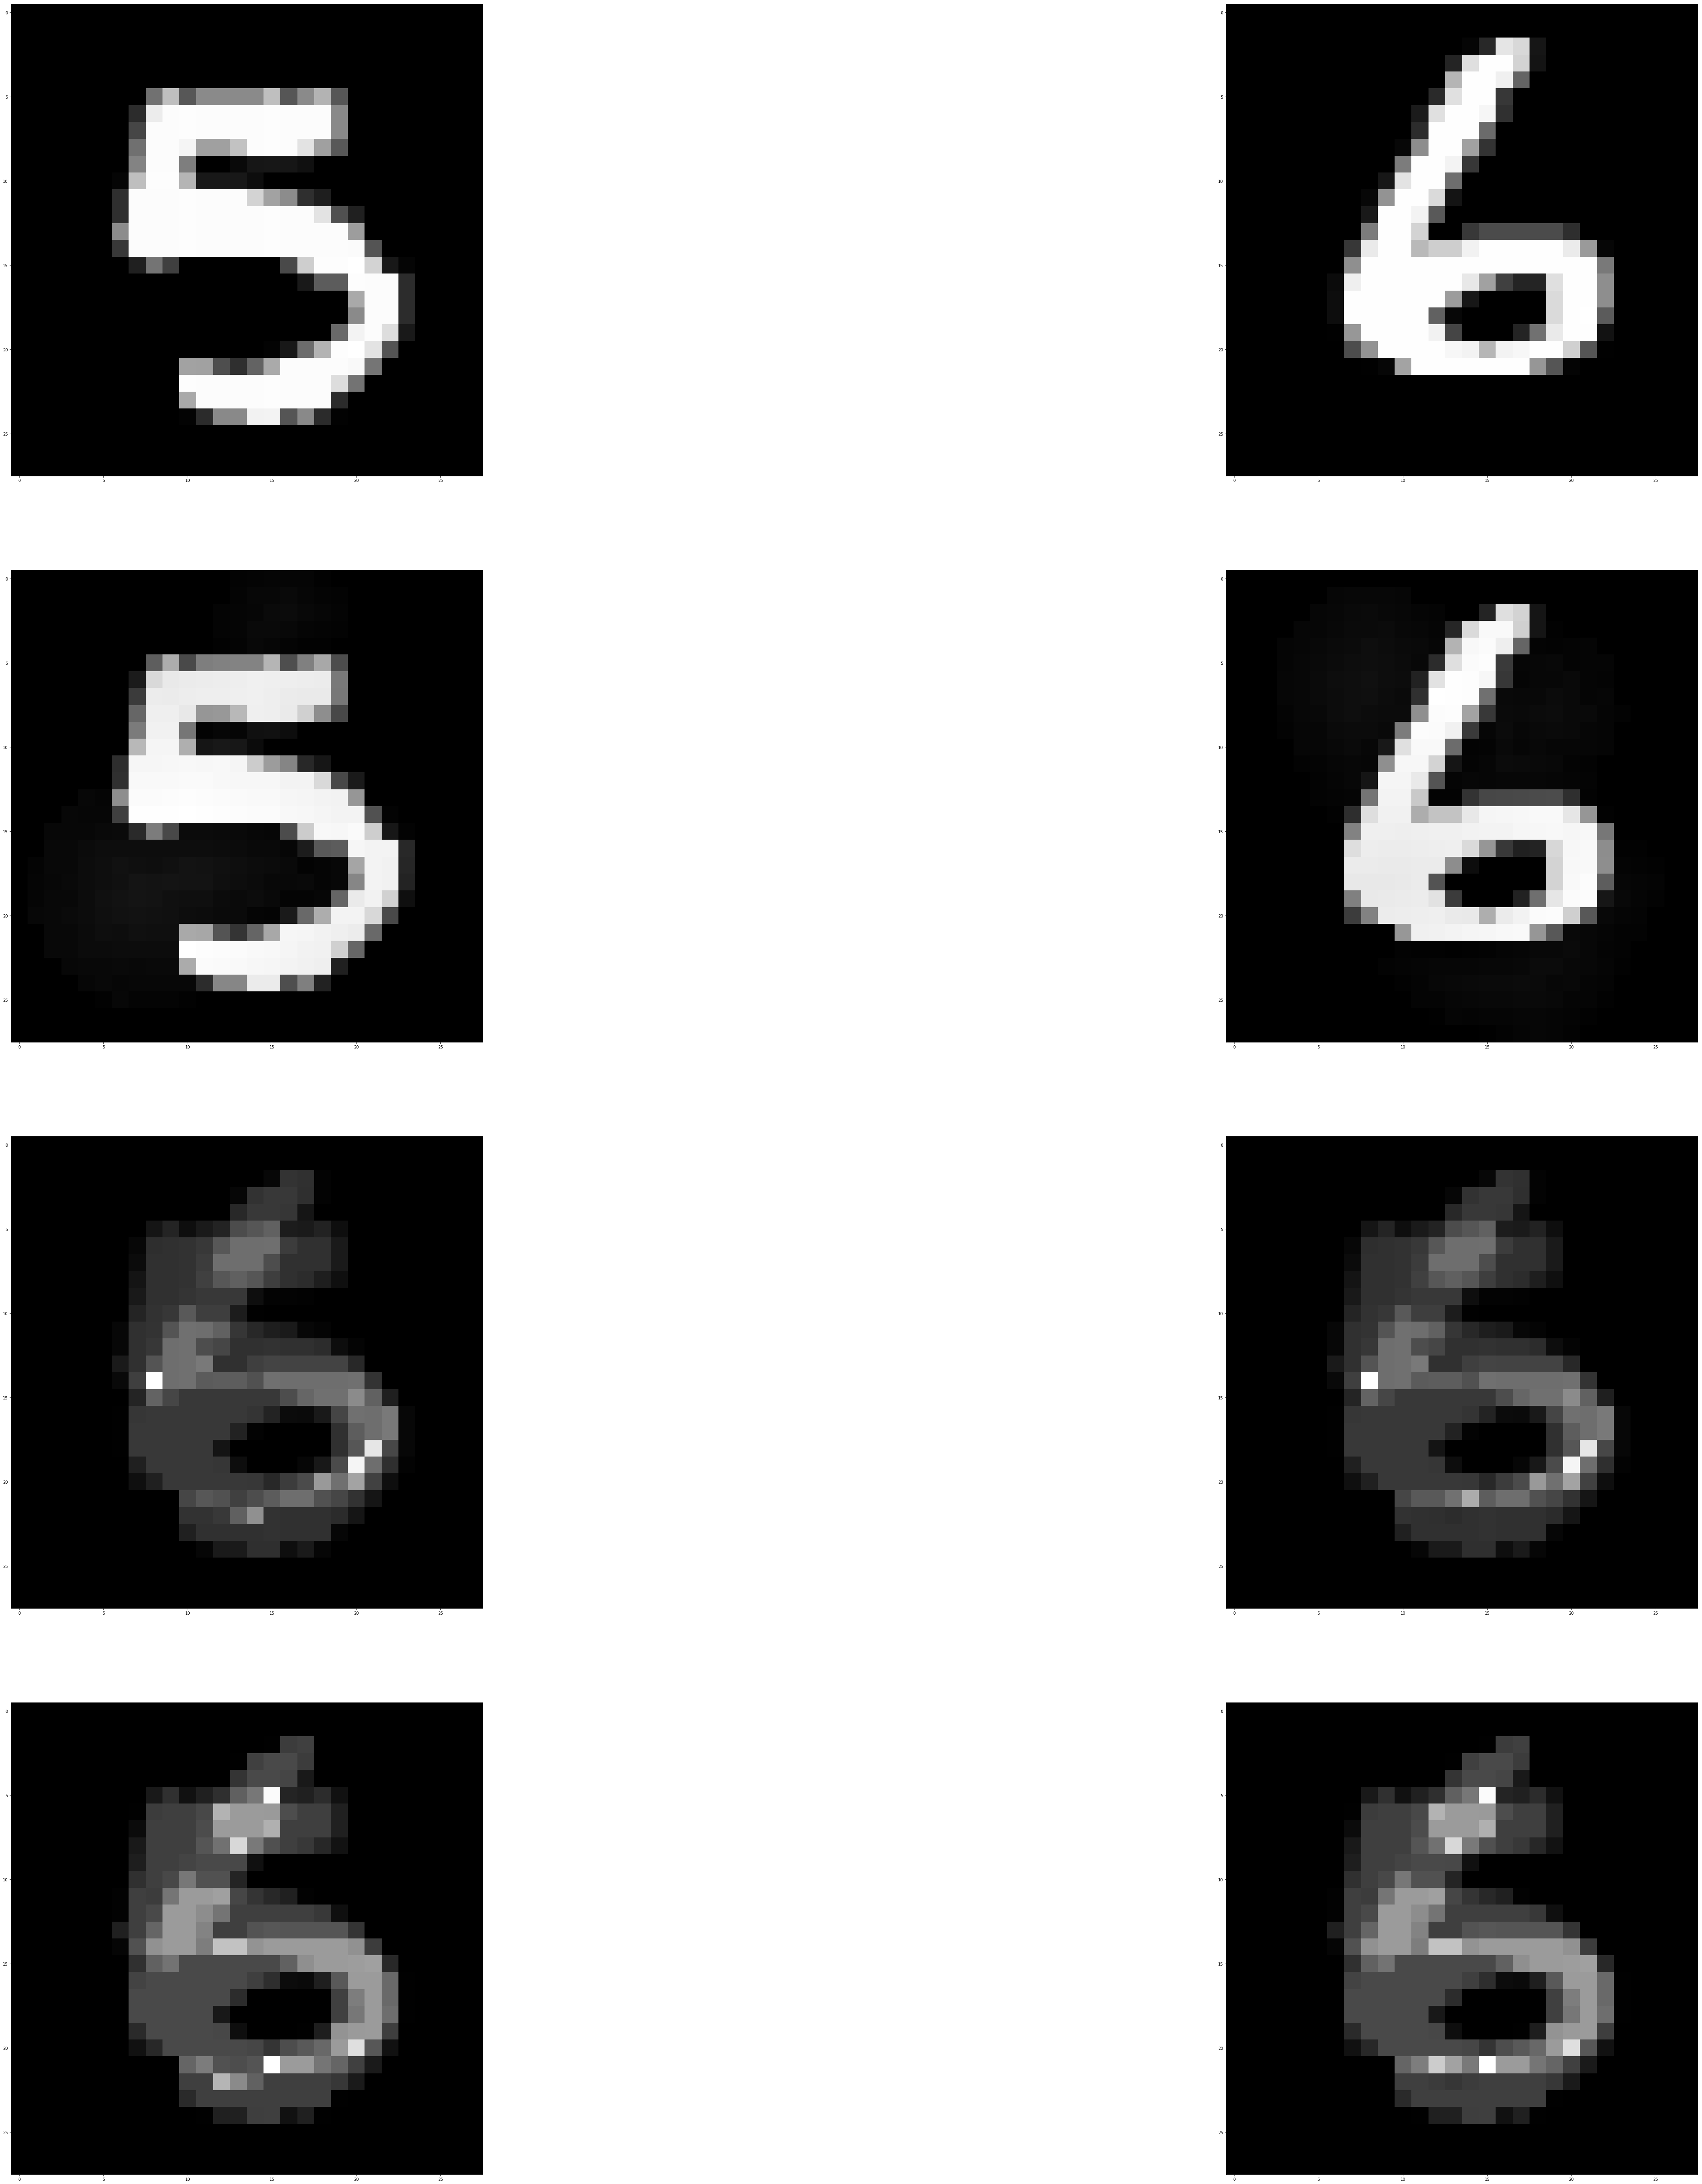

In [20]:
plt.figure(figsize=(100,100))

plt.subplot(421)
plt.imshow(p.reshape(-1, m), cmap=plt.get_cmap('gray'))
plt.subplot(422)
plt.imshow(q.reshape(-1, m), cmap=plt.get_cmap('gray'))

plt.subplot(423)
plt.imshow(xs1[-1].dot(one).reshape(-1, m), cmap=plt.get_cmap('gray'))
plt.subplot(424)
plt.imshow(xs1[-1].T.dot(one).reshape(-1, m), cmap=plt.get_cmap('gray'))

plt.subplot(425)
plt.imshow(xs2[-1].dot(one).reshape(-1, m), cmap=plt.get_cmap('gray'))
plt.subplot(426)
plt.imshow(xs2[-1].T.dot(one).reshape(-1, m), cmap=plt.get_cmap('gray'))

plt.subplot(427)
plt.imshow(xs3[-1].dot(one).reshape(-1, m), cmap=plt.get_cmap('gray'))
plt.subplot(428)
plt.imshow(xs3[-1].T.dot(one).reshape(-1, m), cmap=plt.get_cmap('gray'))

In [21]:
N = min(N1, N2, N3)

### Dual Objective vs. Iterations

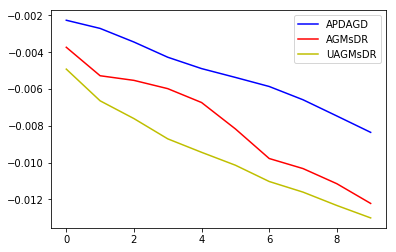

In [22]:
begin = 5
fig, ax = plt.subplots()
ax.plot(phis1[begin:N], '-b', label='APDAGD')
ax.plot(phis2[begin:N], '-r', label='AGMsDR')
ax.plot(phis3[begin:N], '-y', label='UAGMsDR')
leg = ax.legend();

In [23]:
ft1 = np.array([f_true(i) for i in xs1[:]])
ft2 = np.array([f_true(i) for i in xs2[:]])
ft3 = np.array([f_true(i) for i in xs3[:]])

### Non-Regularized Primal vs. Iterations

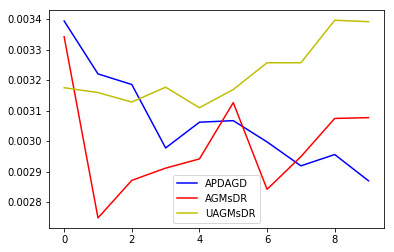

In [24]:
begin = 5
fig, ax = plt.subplots()
ax.plot(ft1[begin:N], '-b', label='APDAGD')
ax.plot(ft2[begin:N], '-r', label='AGMsDR')
ax.plot(ft3[begin:N], '-y', label='UAGMsDR')
leg = ax.legend();

### Constraints Residual vs. Iterations

In [25]:
r1 = np.array([np.linalg.norm(i.dot(one) - p, 1) + np.linalg.norm(i.T.dot(one) - q, 1) for i in xs1[:]])
r2 = np.array([np.linalg.norm(i.dot(one) - p, 1) + np.linalg.norm(i.T.dot(one) - q, 1) for i in xs2[:]])
r3 = np.array([np.linalg.norm(i.dot(one) - p, 1) + np.linalg.norm(i.T.dot(one) - q, 1) for i in xs3[:]])

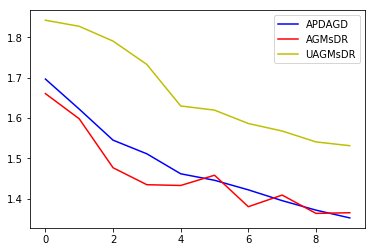

In [26]:
begin = 5
fig, ax = plt.subplots()
ax.plot(r1[begin:N], '-b', label='APDAGD')
ax.plot(r2[begin:N], '-r', label='AGMsDR')
ax.plot(r3[begin:N], '-y', label='UAGMsDR')
leg = ax.legend();

### Non-regularized Primal vs. Iteration with Rounding

In [27]:
fr1 = np.array([f_true(mround(i)) for i in xs1])
fr2 = np.array([f_true(mround(i)) for i in xs2])
fr3 = np.array([f_true(mround(i)) for i in xs3])

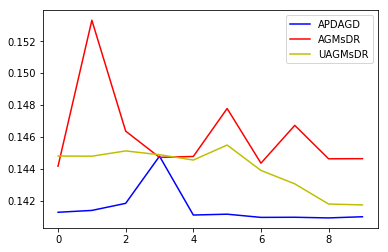

In [28]:
begin = 5
fig, ax = plt.subplots()
ax.plot(fr1[begin:N], '-b', label='APDAGD')
ax.plot(fr2[begin:N], '-r', label='AGMsDR')
ax.plot(fr3[begin:N], '-y', label='UAGMsDR')
leg = ax.legend();

### Dual Objectives vs. Time

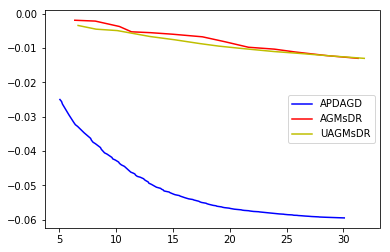

In [29]:
begin=5
fig, ax = plt.subplots()

mask1 = (times1 > begin)
mask2 = (times2 > begin)
mask3 = (times3 > begin)

ax.plot(times1[mask1], phis1[mask1], '-b', label='APDAGD')
ax.plot(times2[mask2], phis2[mask2], '-r', label='AGMsDR')
ax.plot(times3[mask3], phis3[mask3], '-y', label='UAGMsDR')
leg = ax.legend();

### Constraints Residual vs. Time

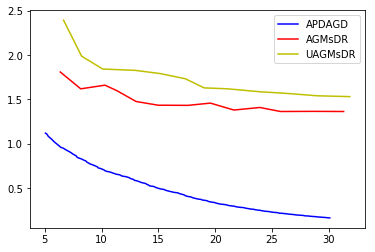

In [30]:
begin=5

mask1 = (times1 > begin)
mask2 = (times2 > begin)
mask3 = (times3 > begin)

fig, ax = plt.subplots()
ax.plot(times1[mask1], r1[mask1], '-b', label='APDAGD')
ax.plot(times2[mask2], r2[mask2], '-r', label='AGMsDR')
ax.plot(times3[mask3], r3[mask3], '-y', label='UAGMsDR')
leg = ax.legend();

### Non-regularized Primal vs. Time with Rounding

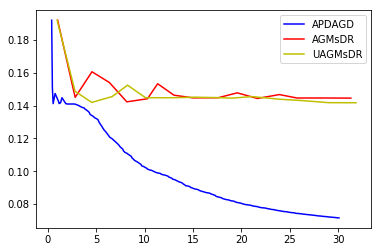

In [31]:
begin=5
fig, ax = plt.subplots()
ax.plot(times1, fr1, '-b', label='APDAGD')
ax.plot(times2, fr2, '-r', label='AGMsDR')
ax.plot(times3, fr3, '-y', label='UAGMsDR')
leg = ax.legend();

# APDAGD vs AGM vs UAGM | $x \in \mathbb S^{n^2}_1$


In [32]:
phis4, xs4, times4, N4 = APDAGD_simplex(wtime)

In [33]:
phis5, xs5, times5, N5 = AGMsDR_simplex(wtime, eps_search, design='u')

In [34]:
phis6, xs6, times6, N6 = UAGMsDR_simplex(wtime, eps_search, eps_f, design='u')

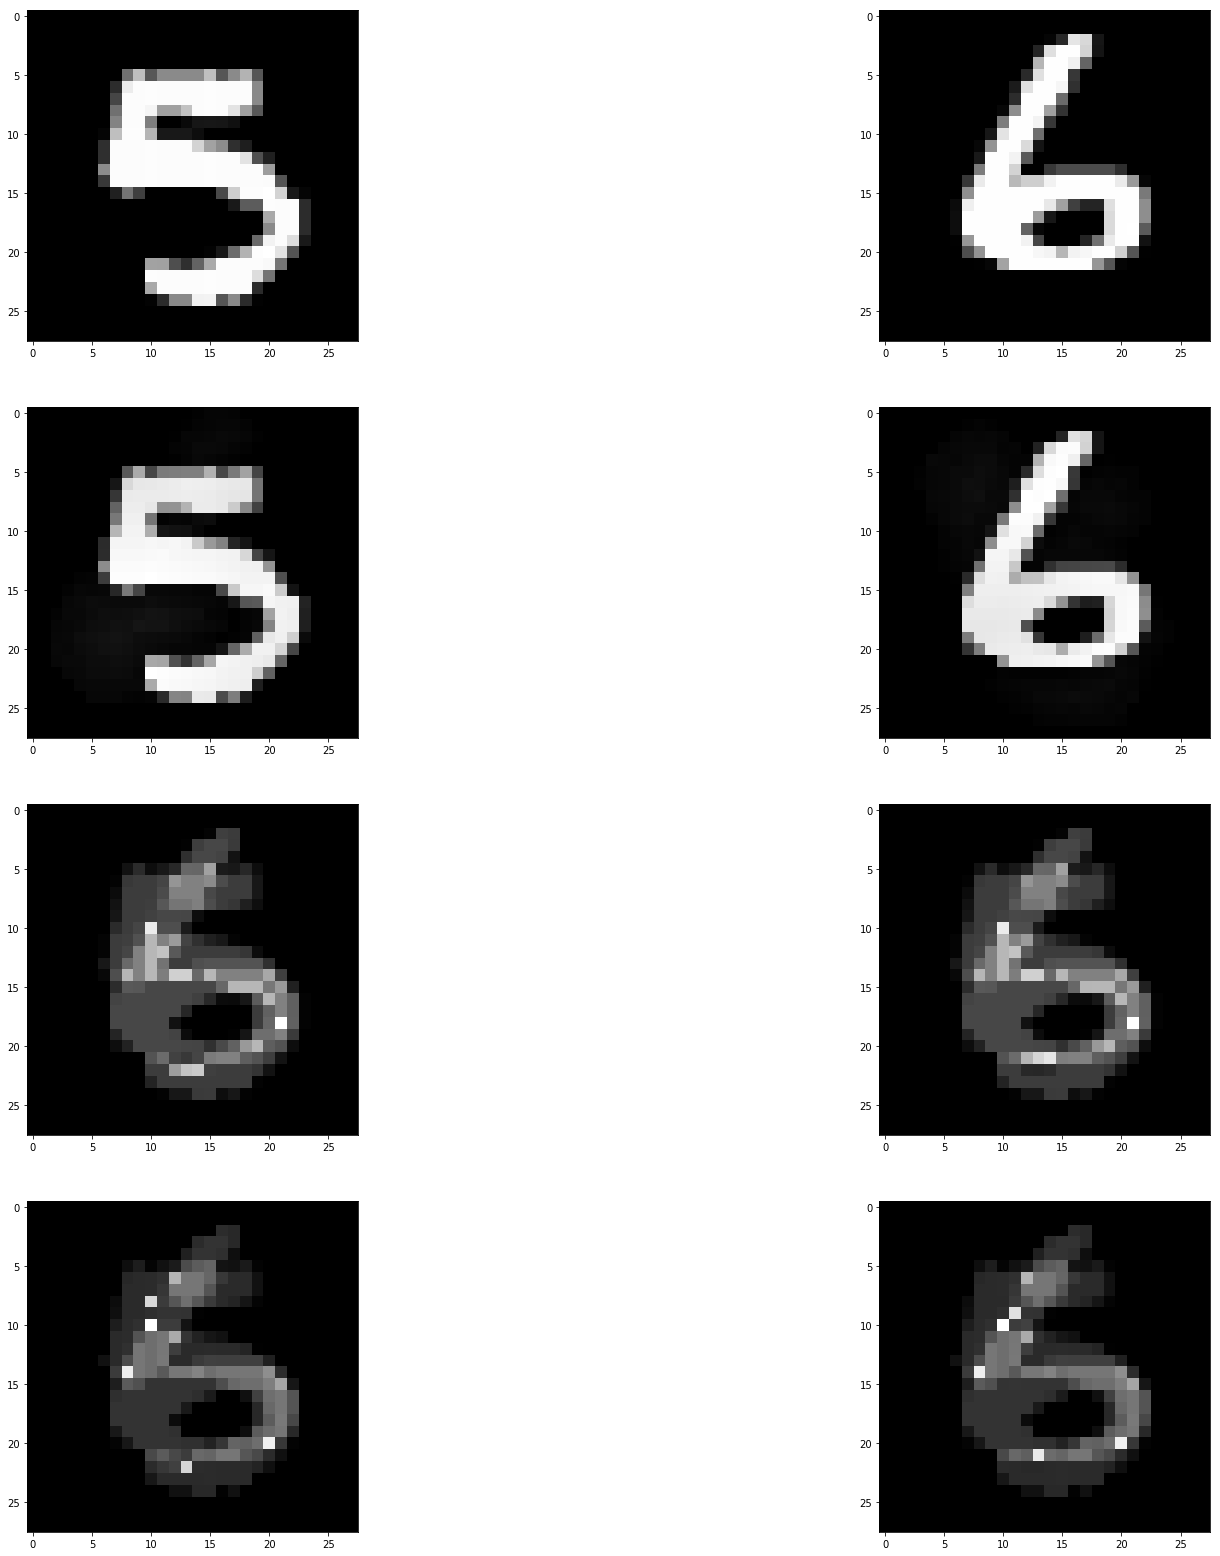

In [35]:
plt.figure(figsize=(28,28))

plt.subplot(421)
plt.imshow(p.reshape(-1, m), cmap=plt.get_cmap('gray'))
plt.subplot(422)
plt.imshow(q.reshape(-1, m), cmap=plt.get_cmap('gray'))


plt.subplot(423)
plt.imshow(xs4[-1].dot(one).reshape(-1, m), cmap=plt.get_cmap('gray'))
plt.subplot(424)
plt.imshow(xs4[-1].T.dot(one).reshape(-1, m), cmap=plt.get_cmap('gray'))

plt.subplot(425)
plt.imshow(xs5[-1].dot(one).reshape(-1, m), cmap=plt.get_cmap('gray'))
plt.subplot(426)
plt.imshow(xs5[-1].T.dot(one).reshape(-1, m), cmap=plt.get_cmap('gray'))

plt.subplot(427)
plt.imshow(xs6[-1].dot(one).reshape(-1, m), cmap=plt.get_cmap('gray'))
plt.subplot(428)
plt.imshow(xs6[-1].T.dot(one).reshape(-1, m), cmap=plt.get_cmap('gray'))


In [36]:
N = min(N4, N5, N6)

### Dual Objective vs. Iterations

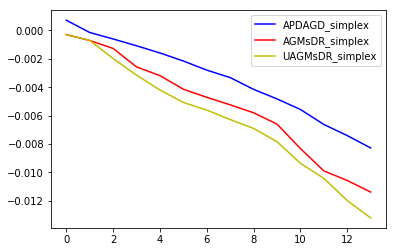

In [37]:
fig, ax = plt.subplots()
ax.plot(phis4[:N], '-b', label='APDAGD_simplex')
ax.plot(phis5[:N], '-r', label='AGMsDR_simplex')
ax.plot(phis6[:N], '-y', label='UAGMsDR_simplex')
leg = ax.legend();

### Non-Regularized Primal vs. Iterations

In [38]:
ft4 = [f_true(i) for i in xs4[:]]
ft5 = [f_true(i) for i in xs5[:]]
ft6 = [f_true(i) for i in xs6[:]]

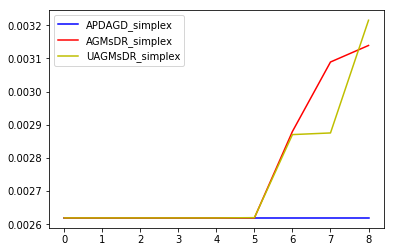

In [39]:
begin = 5
fig, ax = plt.subplots()
ax.plot(ft4[begin:N], '-b', label='APDAGD_simplex')
ax.plot(ft5[begin:N], '-r', label='AGMsDR_simplex')
ax.plot(ft6[begin:N], '-y', label='UAGMsDR_simplex')
leg = ax.legend();

### Constraints Residual vs. Iterations

In [40]:
r4 = np.array([np.linalg.norm(i.dot(one) - p, 1) + np.linalg.norm(i.T.dot(one) - q, 1) for i in xs4[:]])
r5 = np.array([np.linalg.norm(i.dot(one) - p, 1) + np.linalg.norm(i.T.dot(one) - q, 1) for i in xs5[:]])
r6 = np.array([np.linalg.norm(i.dot(one) - p, 1) + np.linalg.norm(i.T.dot(one) - q, 1) for i in xs6[:]])

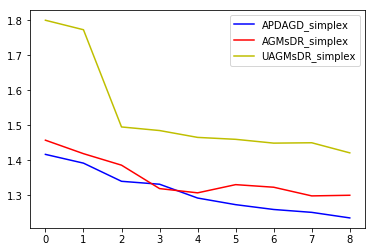

In [41]:
begin = 5
fig, ax = plt.subplots()
ax.plot(r4[begin:N], '-b', label='APDAGD_simplex')
ax.plot(r5[begin:N], '-r', label='AGMsDR_simplex')
ax.plot(r6[begin:N], '-y', label='UAGMsDR_simplex')
leg = ax.legend();

### Non-regularized Primal vs. Iteration with Rounding

In [42]:
fr4 = np.array([f_true(mround(i)) for i in xs4])
fr5 = np.array([f_true(mround(i)) for i in xs5])
fr6 = np.array([f_true(mround(i)) for i in xs6])

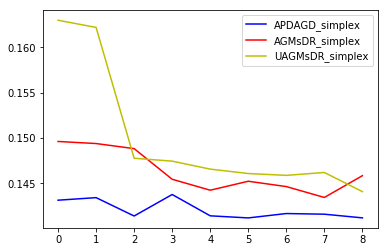

In [43]:
begin = 5
fig, ax = plt.subplots()
ax.plot(fr4[begin:N], '-b', label='APDAGD_simplex')
ax.plot(fr5[begin:N], '-r', label='AGMsDR_simplex')
ax.plot(fr6[begin:N], '-y', label='UAGMsDR_simplex')
leg = ax.legend();

### Dual Objectives vs. Time

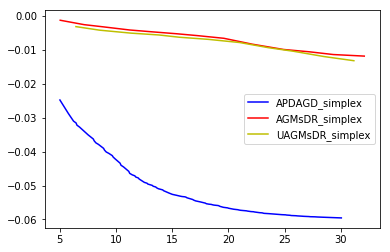

In [44]:
begin=5
fig, ax = plt.subplots()

mask4 = (times4 > begin)
mask5 = (times5 > begin)
mask6 = (times6 > begin)

ax.plot(times4[mask4], phis4[mask4], '-b', label='APDAGD_simplex')
ax.plot(times5[mask5], phis5[mask5], '-r', label='AGMsDR_simplex')
ax.plot(times6[mask6], phis6[mask6], '-y', label='UAGMsDR_simplex')

leg = ax.legend();

### Constraints Residual vs. Time

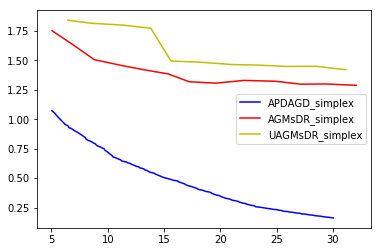

In [45]:
begin=5

mask4 = (times4 > begin)
mask5 = (times5 > begin)
mask6 = (times6 > begin)

fig, ax = plt.subplots()
ax.plot(times4[mask4], r4[mask4], '-b', label='APDAGD_simplex')
ax.plot(times5[mask5], r5[mask5], '-r', label='AGMsDR_simplex')
ax.plot(times6[mask6], r6[mask6], '-y', label='UAGMsDR_simplex')
leg = ax.legend();

### Non-regularized Primal vs. Time with Rounding

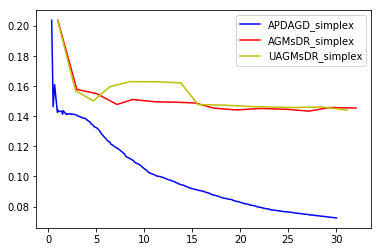

In [46]:
begin=5
fig, ax = plt.subplots()
ax.plot(times4, fr4, '-b', label='APDAGD_simplex')
ax.plot(times5, fr5, '-r', label='AGMsDR_simplex')
ax.plot(times6, fr6, '-y', label='UAGMsDR_simplex')
leg = ax.legend();

# APDAGD | $x \in \mathbb S^{n^2}_1$ vs. $x \in \mathbb R^{n^2}_+$

In [47]:
N = min(N1, N4)

### Dual Objective vs. Iterations

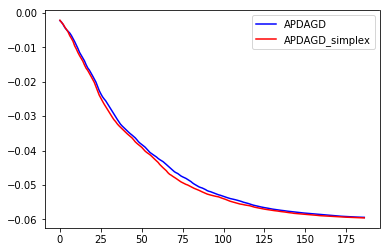

In [48]:
begin = 5
fig, ax = plt.subplots()
ax.plot(phis1[begin:N], '-b', label='APDAGD')
ax.plot(phis4[begin:N], '-r', label='APDAGD_simplex')
leg = ax.legend();

### Constraints Residual vs. Iterations

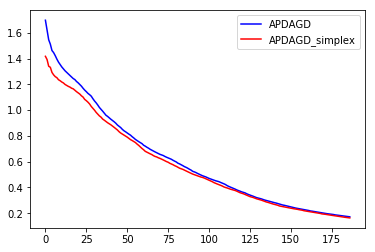

In [49]:
begin = 5
fig, ax = plt.subplots()
ax.plot(r1[begin:N], '-b', label='APDAGD')
ax.plot(r4[begin:N], '-r', label='APDAGD_simplex')
leg = ax.legend();

### Constraints Residual vs. Time

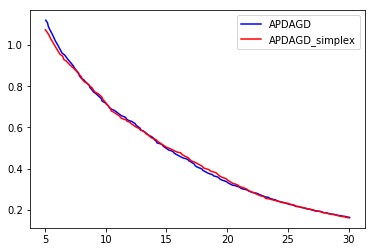

In [50]:
begin=5
fig, ax = plt.subplots()
ax.plot(times1[times1>begin], r1[times1>begin], '-b', label='APDAGD')
ax.plot(times4[times4>begin], r4[times4>begin], '-r', label='APDAGD_simplex')
leg = ax.legend();

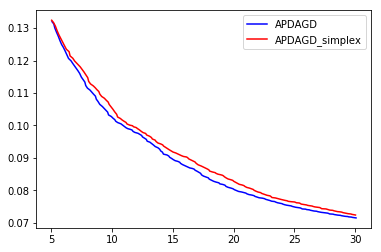

In [51]:
begin=5
fig, ax = plt.subplots()
ax.plot(times1[times1>begin], fr1[times1>begin], '-b', label='APDAGD')
ax.plot(times4[times4>begin], fr4[times4>begin], '-r', label='APDAGD_simplex')
leg = ax.legend();

# UAGM | $x \in \mathbb S^{n^2}_1$ vs. $x \in \mathbb R^{n^2}_+$

In [52]:
N = min(N3, N6)

### Dual Objective vs. Iterations

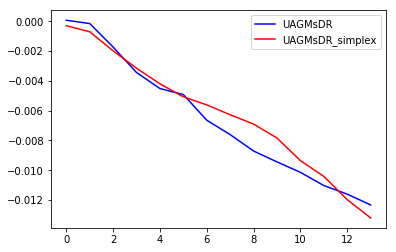

In [53]:
begin = 0
fig, ax = plt.subplots()
ax.plot(phis3[begin:N], '-b', label='UAGMsDR')
ax.plot(phis6[begin:N], '-r', label='UAGMsDR_simplex')
leg = ax.legend();

### Constraints Residual vs. Iterations

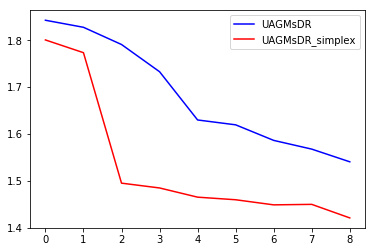

In [54]:
begin = 5
fig, ax = plt.subplots()
ax.plot(r3[begin:N], '-b', label='UAGMsDR')
ax.plot(r6[begin:N], '-r', label='UAGMsDR_simplex')
leg = ax.legend();

### Constraints Residual vs. Time

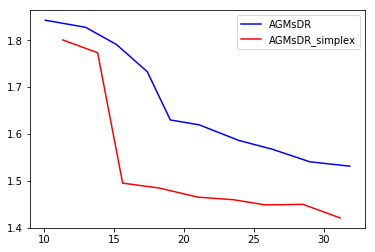

In [55]:
begin=10
fig, ax = plt.subplots()
ax.plot(times3[times3>begin], r3[times3>begin], '-b', label='AGMsDR')
ax.plot(times6[times6>begin], r6[times6>begin], '-r', label='AGMsDR_simplex')
leg = ax.legend();

### Non-regularized Primal vs. Time with Rounding

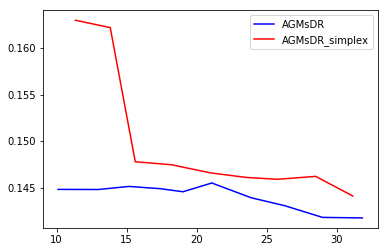

In [56]:
begin=10
fig, ax = plt.subplots()
ax.plot(times3[times3>begin], fr3[times3>begin], '-b', label='AGMsDR')
ax.plot(times6[times6>begin], fr6[times6>begin], '-r', label='AGMsDR_simplex')
leg = ax.legend();

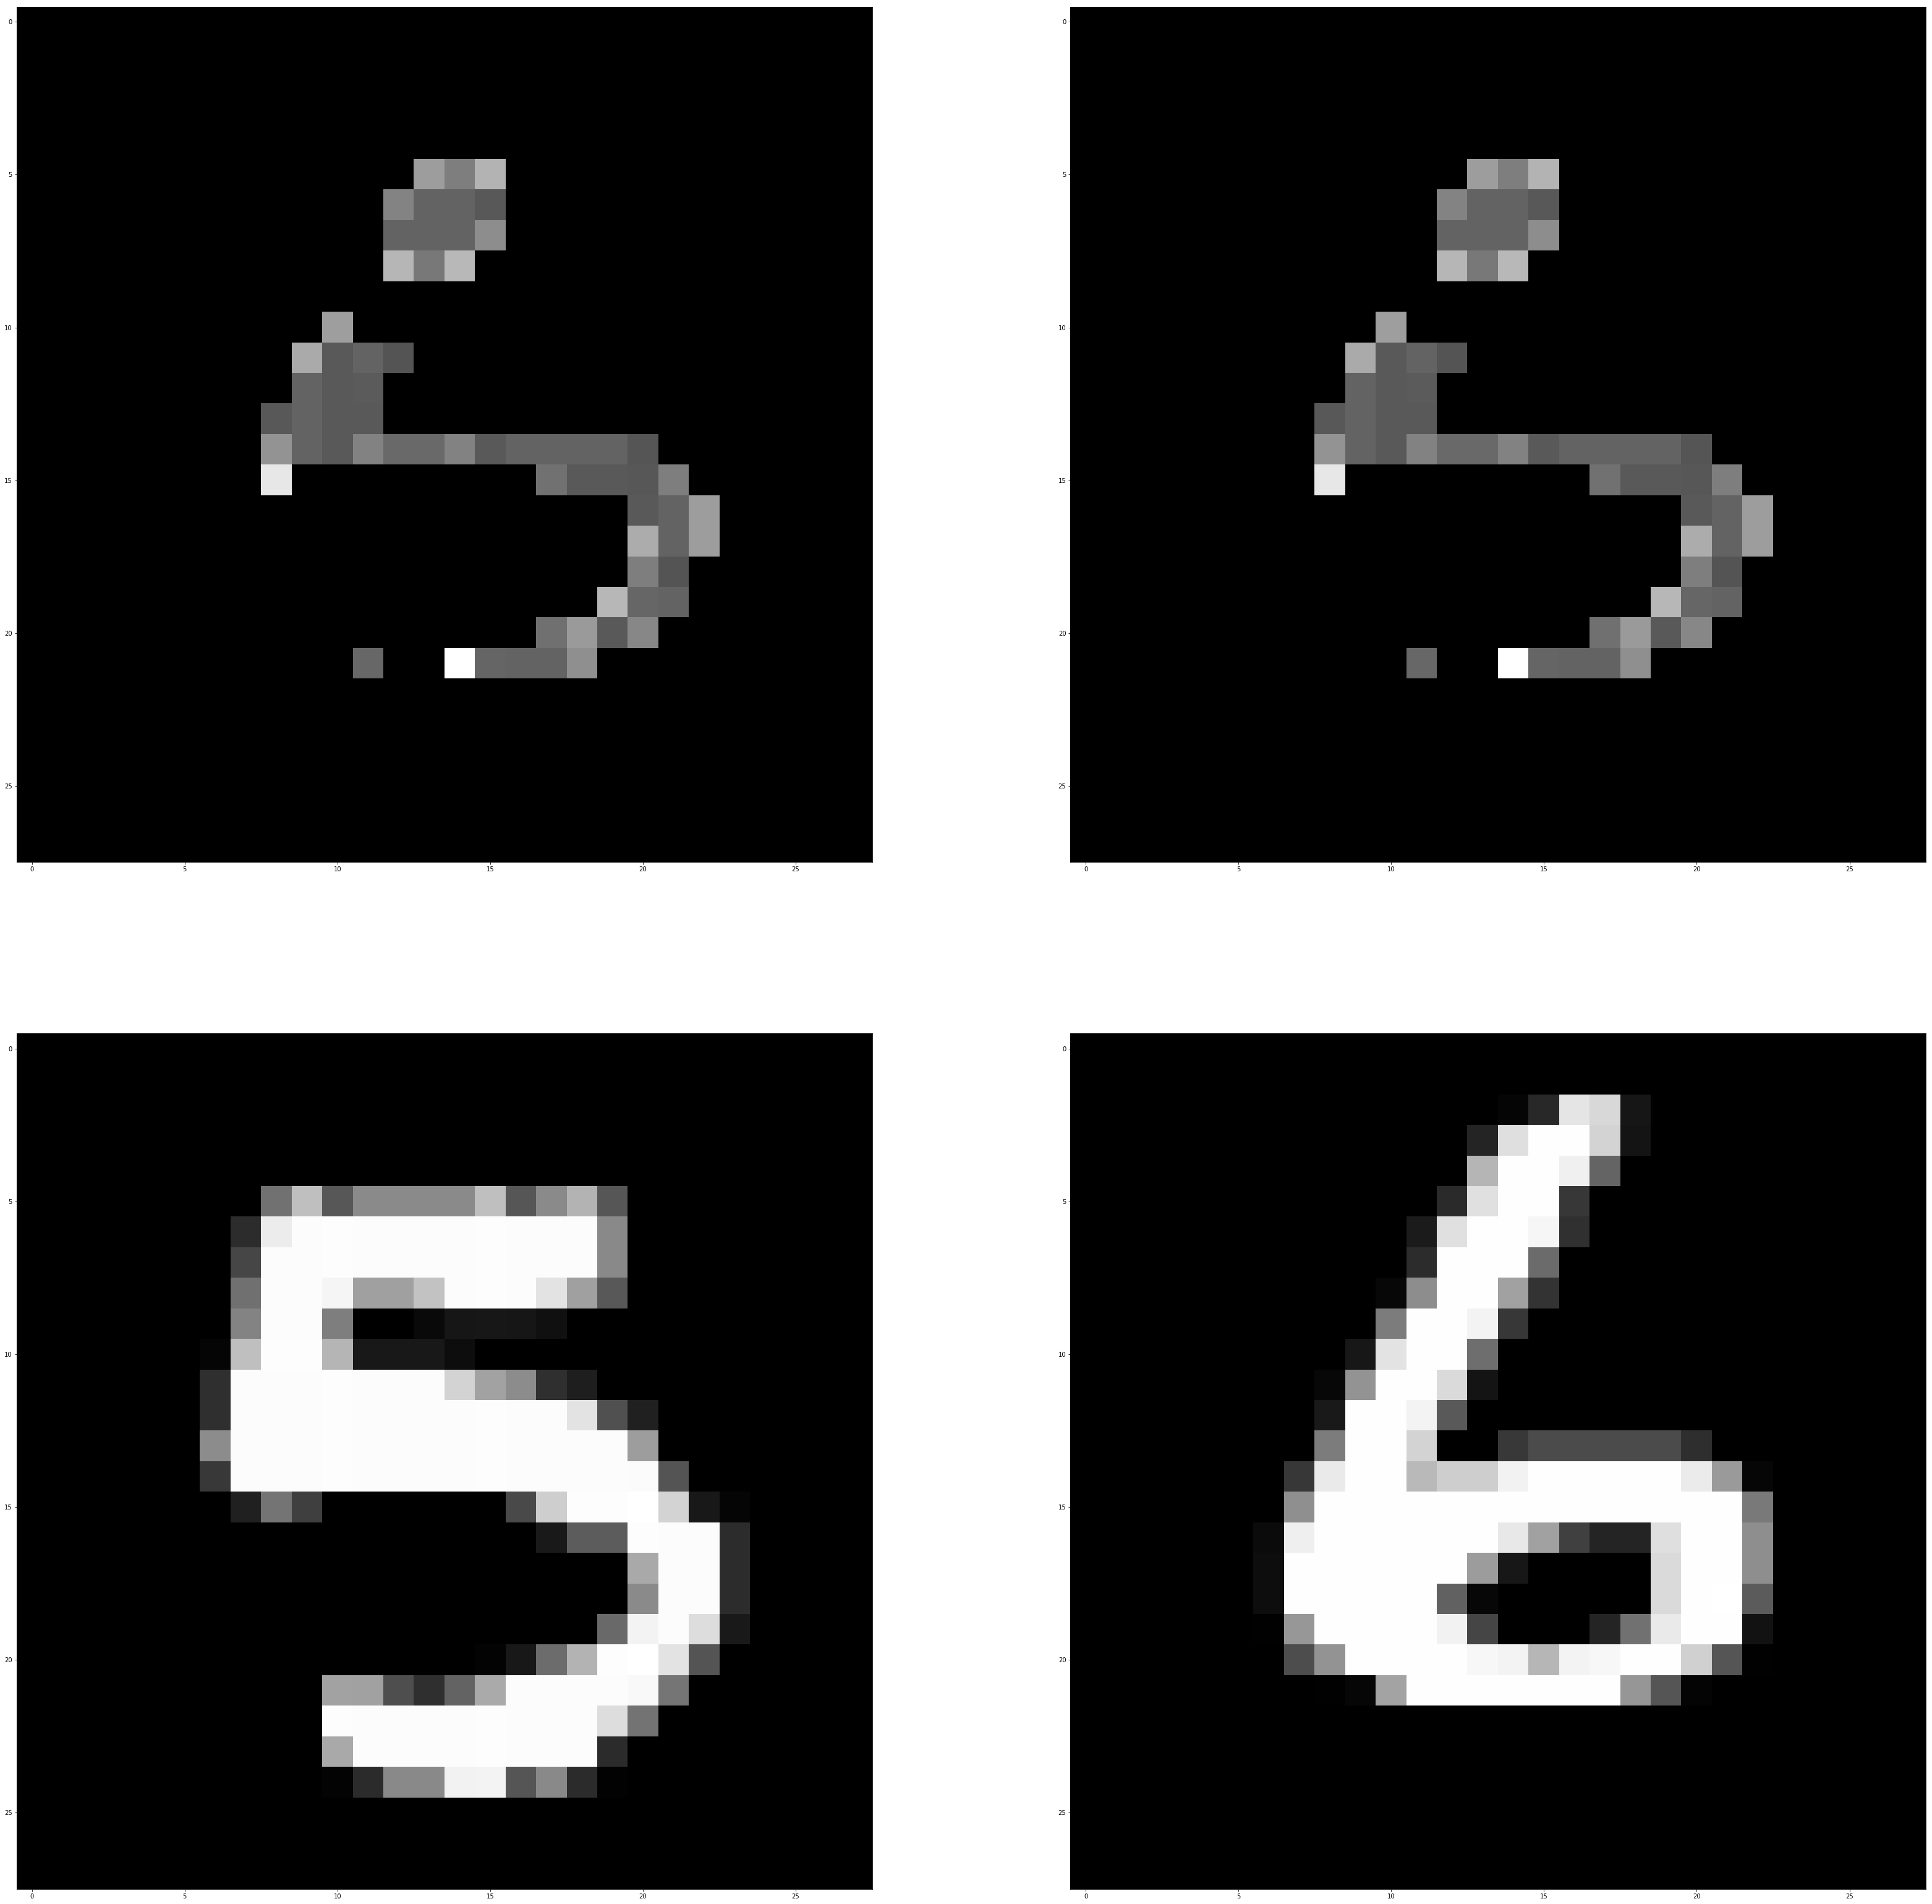

In [57]:
eps_search1 = 1e-2
eps_search2 = 1e-3
eps_f = 1e-1
wtime = 30
phis7, xs7, times7, N7 = PDUGDsDR(wtime, eps_search1, eps_search2, eps_f)

plt.figure(figsize=(56,56))

plt.subplot(223)
plt.imshow(p.reshape(-1, m), cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(q.reshape(-1, m), cmap=plt.get_cmap('gray'))

plt.subplot(221)
plt.imshow((xs7[-1]).dot(one).reshape(-1, m), cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow((xs7[-1]).T.dot(one).reshape(-1, m), cmap=plt.get_cmap('gray'))


In [58]:
N = min(N1, N5, N6, N7)

In [59]:
ft7 = np.array([f_true(i) for i in xs7[:]])
r7 = np.array([np.linalg.norm(i.dot(one) - p, 1) + np.linalg.norm(i.T.dot(one) - q, 1) for i in xs7[:]])
fr7 = np.array([f_true(mround(i)) for i in xs7])

### Non-regularized primal vs Iterations

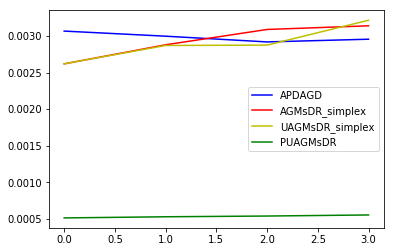

In [60]:
begin = 10
fig, ax = plt.subplots()
ax.plot(ft1[begin:N], '-b', label='APDAGD')
ax.plot(ft5[begin:N], '-r', label='AGMsDR_simplex')
ax.plot(ft6[begin:N], '-y', label='UAGMsDR_simplex')
ax.plot(ft7[begin:N], '-g', label='PUAGMsDR')
leg = ax.legend();

### Constraints Residual vs. Iterations

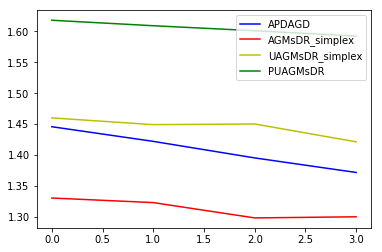

In [61]:
begin = 10
fig, ax = plt.subplots()
ax.plot(r1[begin:N], '-b', label='APDAGD')
ax.plot(r5[begin:N], '-r', label='AGMsDR_simplex')
ax.plot(r6[begin:N], '-y', label='UAGMsDR_simplex')
ax.plot(r7[begin:N], '-g', label='PUAGMsDR')
leg = ax.legend();

### Non-regularized Primal vs. Iteration with Rounding

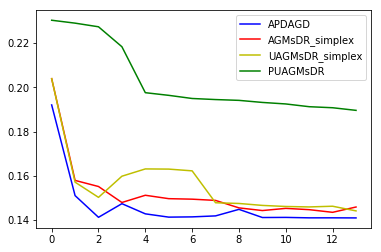

In [62]:
begin = 0
fig, ax = plt.subplots()
ax.plot(fr1[begin:N], '-b', label='APDAGD')
ax.plot(fr5[begin:N], '-r', label='AGMsDR_simplex')
ax.plot(fr6[begin:N], '-y', label='UAGMsDR_simplex')
ax.plot(fr7[begin:N], '-g', label='PUAGMsDR')
leg = ax.legend();

### Constraints Residual vs. Time

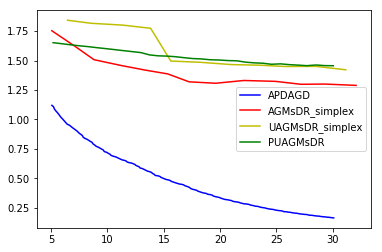

In [63]:
begin = 5
fig, ax = plt.subplots()
ax.plot(times1[times1 > begin], r1[times1 > begin], '-b', label='APDAGD')
ax.plot(times5[times5 > begin], r5[times5 > begin], '-r', label='AGMsDR_simplex')
ax.plot(times6[times6 > begin], r6[times6 > begin], '-y', label='UAGMsDR_simplex')
ax.plot(times7[times7 > begin], r7[times7 > begin], '-g', label='PUAGMsDR')
leg = ax.legend();

### Non-regularized Primal vs. Time with Rounding

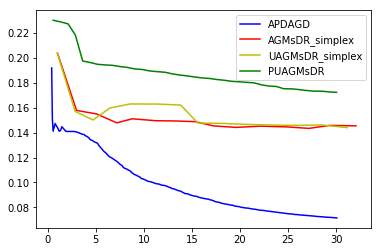

In [64]:
begin = 0
fig, ax = plt.subplots()
ax.plot(times1[times1 > begin], fr1[times1 > begin], '-b', label='APDAGD')
ax.plot(times5[times5 > begin], fr5[times5 > begin], '-r', label='AGMsDR_simplex')
ax.plot(times6[times6 > begin], fr6[times6 > begin], '-y', label='UAGMsDR_simplex')
ax.plot(times7[times7 > begin], fr7[times7 > begin], '-g', label='PUAGMsDR')
leg = ax.legend();

In [65]:
wtime = 30
eps_search1 = 1e-2
eps_search2 = 1e-3
eps_f = 1
phis8, xs8, times8, N8 = PDUGDsDR(wtime, eps_search1, eps_search2, eps_f)
ft8 = np.array([f_true(i) for i in xs8[:]])
r8 = np.array([np.linalg.norm(i.dot(one) - p, 1) + np.linalg.norm(i.T.dot(one) - q, 1) for i in xs8[:]])
fr8 = np.array([f_true(mround(i)) for i in xs8])

In [66]:
wtime = 30
eps_search1 = 1e-2
eps_search2 = 1e-3
eps_f = 1e+2
phis9, xs9, times9, N9 = PDUGDsDR(wtime, eps_search1, eps_search2, eps_f)
ft9 = np.array([f_true(i) for i in xs9[:]])
r9 = np.array([np.linalg.norm(i.dot(one) - p, 1) + np.linalg.norm(i.T.dot(one) - q, 1) for i in xs9[:]])
fr9 = np.array([f_true(mround(i)) for i in xs9])

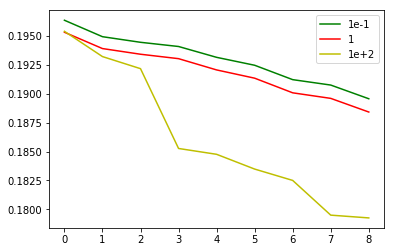

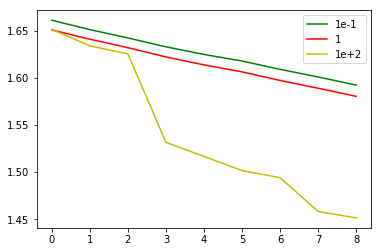

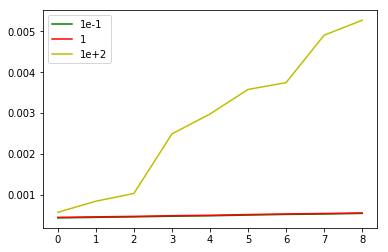

In [67]:
#primal witn rounding
begin = 5
fig, ax = plt.subplots()
ax.plot(fr7[begin:N], '-g', label='1e-1')
ax.plot(fr8[begin:N], '-r', label='1')
ax.plot(fr9[begin:N], '-y', label='1e+2')
leg = ax.legend();

#constraint residual
fig, ax = plt.subplots()
ax.plot(r7[begin:N], '-g', label='1e-1')
ax.plot(r8[begin:N], '-r', label='1')
ax.plot(r9[begin:N], '-y', label='1e+2')
leg = ax.legend();

#primal non-regularized
fig, ax = plt.subplots()
ax.plot(ft7[begin:N], '-g', label='1e-1')
ax.plot(ft8[begin:N], '-r', label='1')
ax.plot(ft9[begin:N], '-y', label='1e+2')
leg = ax.legend();

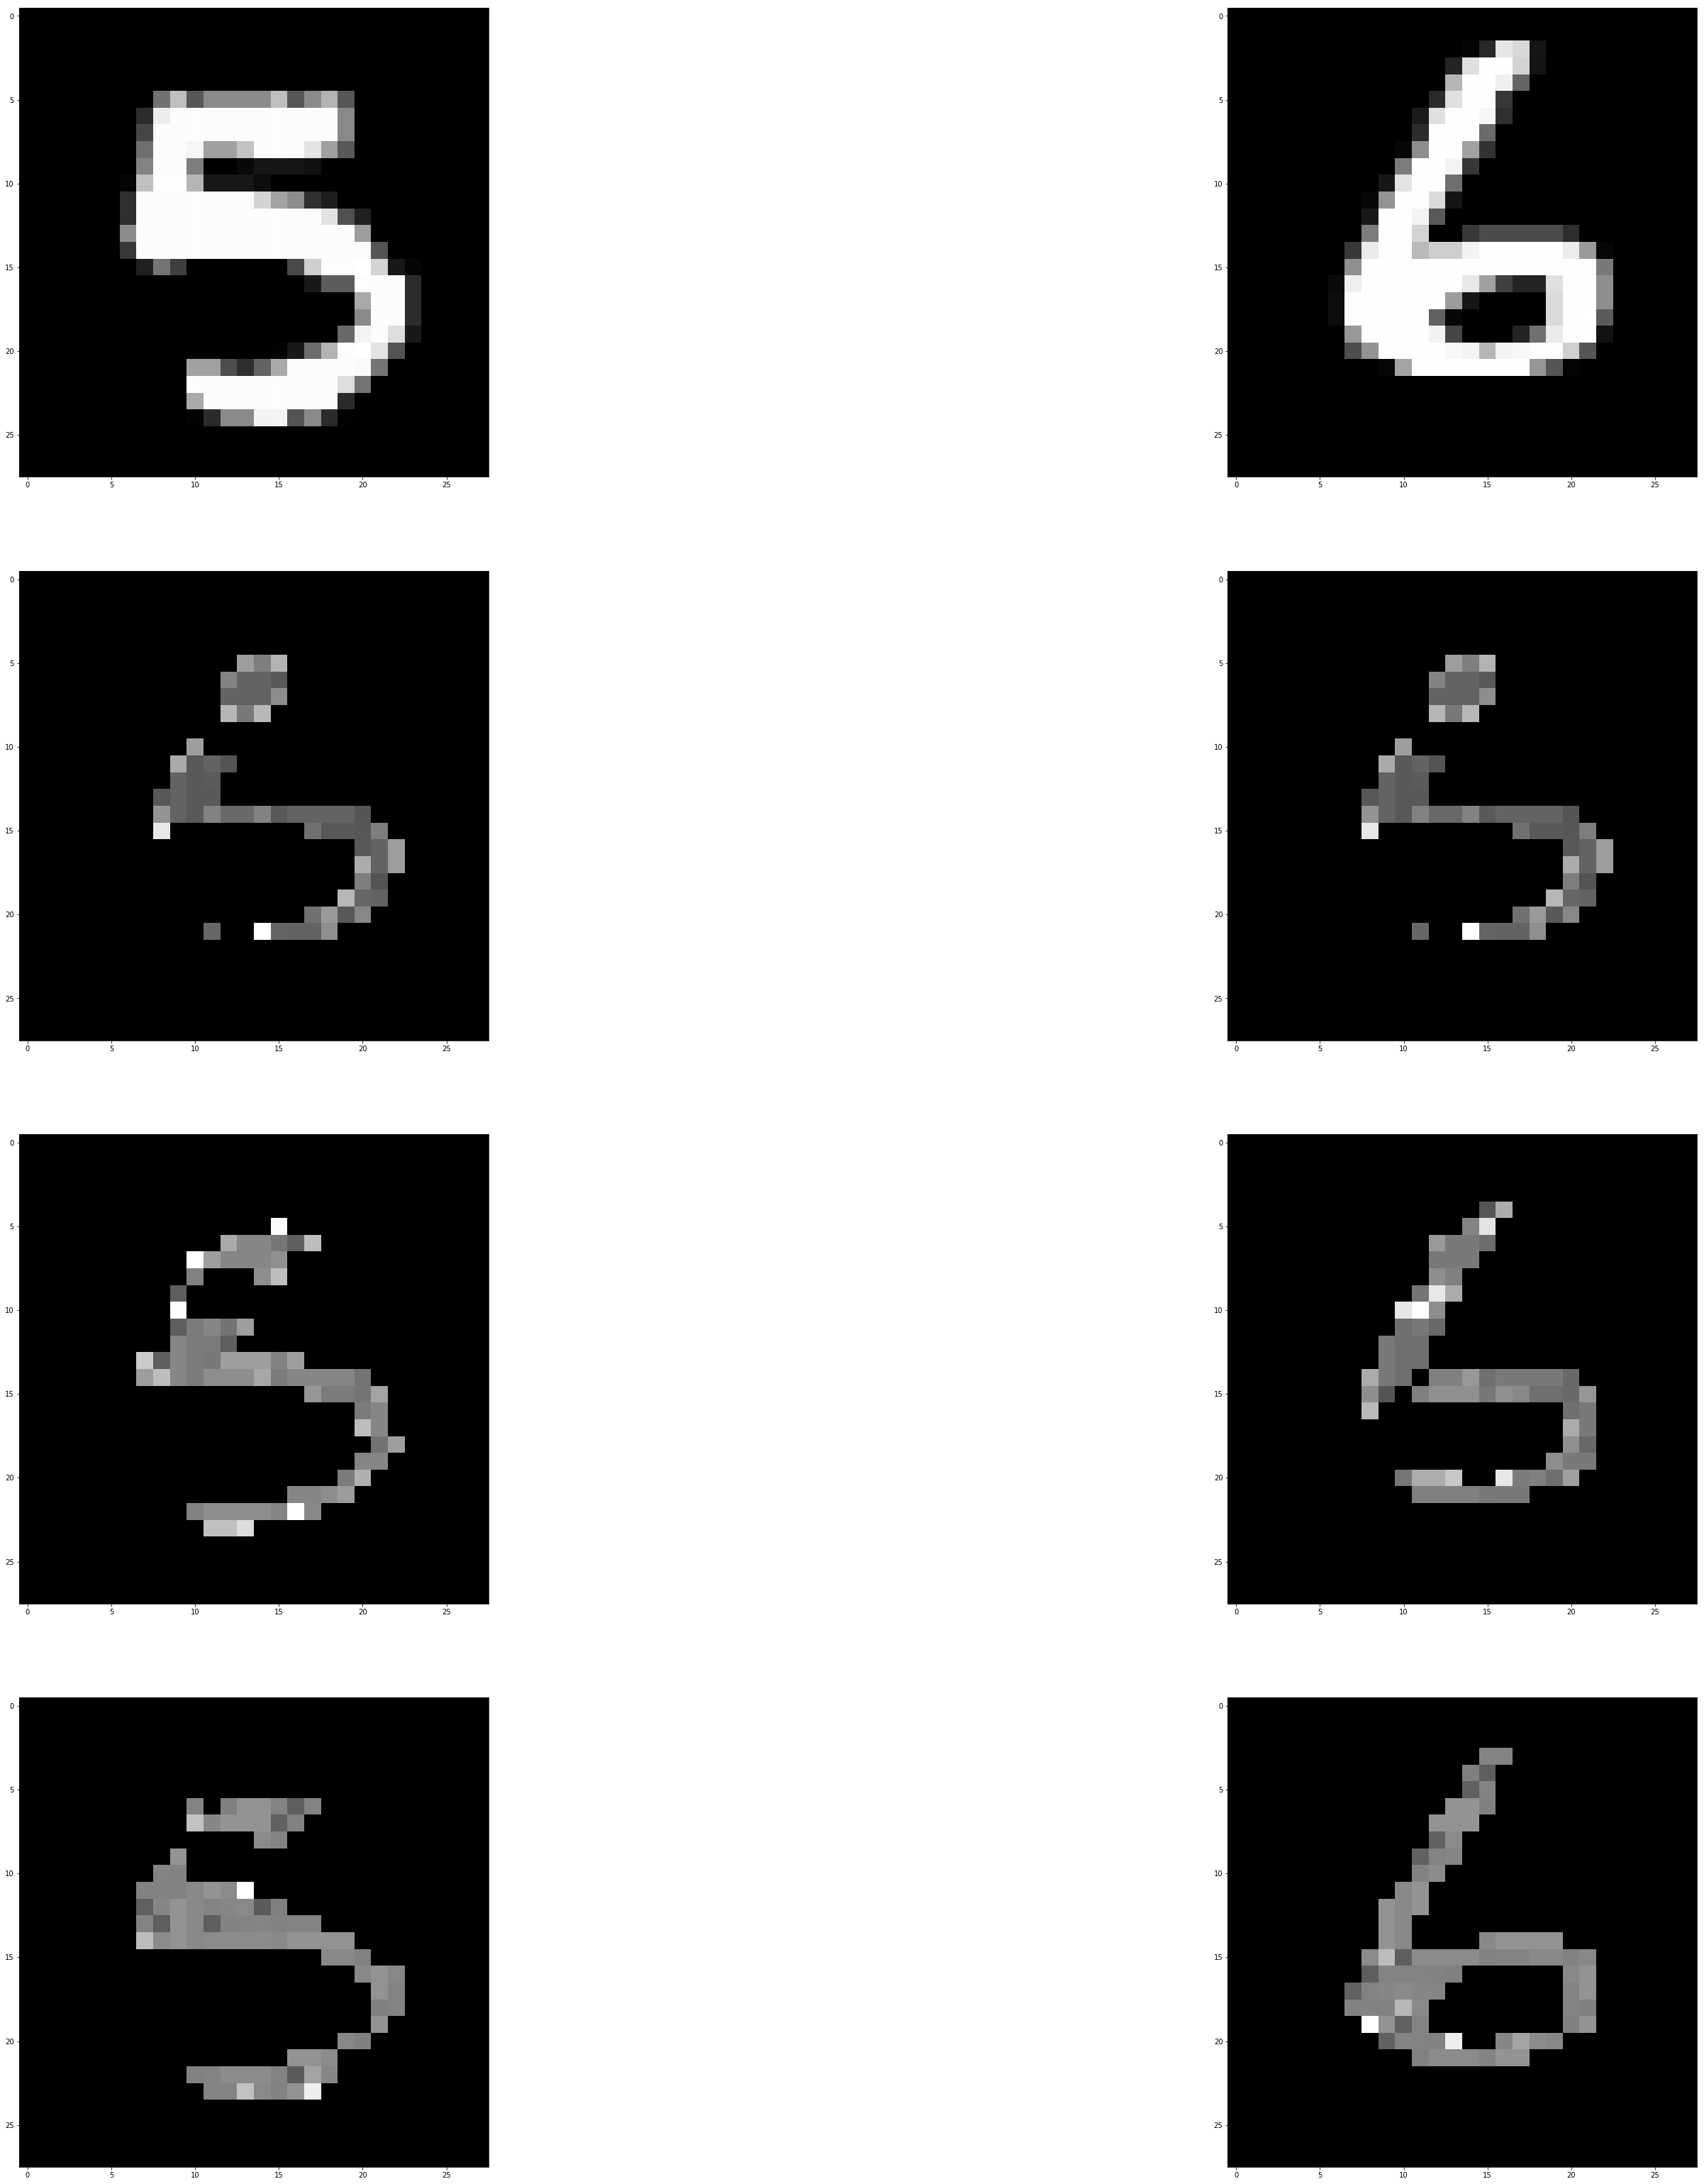

In [68]:
plt.figure(figsize=(56,56))

plt.subplot(421)
plt.imshow(p.reshape(-1, m), cmap=plt.get_cmap('gray'))
plt.subplot(422)
plt.imshow(q.reshape(-1, m), cmap=plt.get_cmap('gray'))

plt.subplot(423)
plt.imshow((xs7[-1]).dot(one).reshape(-1, m), cmap=plt.get_cmap('gray'))
plt.subplot(424)
plt.imshow((xs7[-1]).T.dot(one).reshape(-1, m), cmap=plt.get_cmap('gray'))

plt.subplot(425)
plt.imshow((xs8[-1]).dot(one).reshape(-1, m), cmap=plt.get_cmap('gray'))
plt.subplot(426)
plt.imshow((xs8[-1]).T.dot(one).reshape(-1, m), cmap=plt.get_cmap('gray'))

plt.subplot(427)
plt.imshow((xs9[-1]).dot(one).reshape(-1, m), cmap=plt.get_cmap('gray'))
plt.subplot(428)
plt.imshow((xs9[-1]).T.dot(one).reshape(-1, m), cmap=plt.get_cmap('gray'))